In [2]:
# Allows to make changes to the classes without restarting the notebook 💀 # TODO: Delete once done
%load_ext autoreload
%autoreload 2

In [3]:
from src.model.agents.Hive import Hive
from src.model.agents.BeeSwarm import BeeSwarm
from src.model.agents.Resource import Resource
from src.model.Model import ForagerModel

from src.model.config.HiveConfig import HiveConfig
from src.model.config.BeeSwarmConfig import BeeSwarmConfig
from src.model.config.ResourceConfig import ResourceConfig
from src.model.config.ModelConfig import ModelConfig

from src.model.util.BeeState import BeeState
import src.model.util.ModelBuilder as ModelBuilder

In [30]:
import mesa
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta, expon
from tqdm.notebook import tqdm
from multiprocess.pool import Pool
from scipy import interpolate
import os

In [5]:
FIGURE_PATH = "./fig"

# 0) Baseline model dynamics

In [6]:
from baseline_dynamics import BEE_COUNT_FILE, NECTAR_FILE, RECRUITED_FILE, EXPLORERS_FILE

In [7]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

TRUNCATE_THRESHOLD = 800
SURVIVAL_THRESHOLD = 150

BEE_COUNT_DATA = BEE_COUNT_DATA[:, :TRUNCATE_THRESHOLD]
NECTAR_DATA = NECTAR_DATA[:, :TRUNCATE_THRESHOLD]
EXPLORERS_DATA = EXPLORERS_DATA[:, :TRUNCATE_THRESHOLD]
RECRUITED_DATA = RECRUITED_DATA[:, :TRUNCATE_THRESHOLD]
FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

FINAL_BEE_COUNT = BEE_COUNT_DATA[:, -1]

### Survived colonies (final bee count at least 150)

In [8]:
print(f"{np.round(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD].shape[0] / BEE_COUNT_DATA.shape[0], 4) * 100}% colonies survived")

65.23% colonies survived


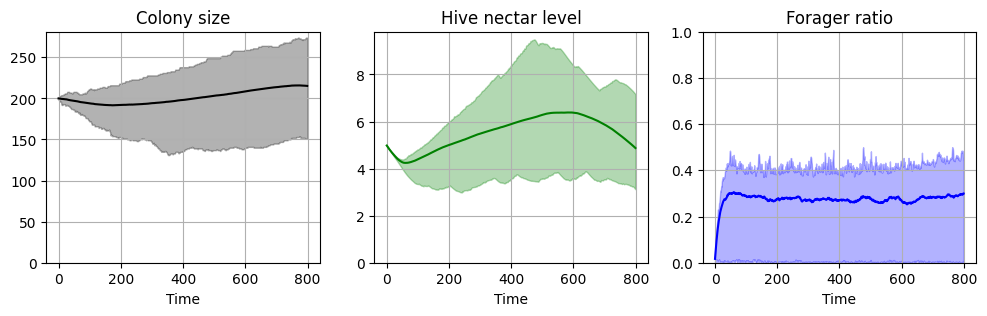

In [9]:
TIME = np.arange(0, BEE_COUNT_DATA.shape[1])

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].fill_between(TIME, np.max(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="black", alpha=0.3)
axes[0].plot(TIME, np.mean(BEE_COUNT_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="black")
axes[0].set_title("Colony size")

axes[1].fill_between(TIME, np.max(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="green", alpha=0.3)
axes[1].plot(TIME, np.mean(NECTAR_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="green")
axes[1].set_title("Hive nectar level")

axes[2].fill_between(TIME, np.max(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), np.min(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="blue", alpha=0.3)
axes[2].plot(TIME, np.mean(FORAGER_DATA[FINAL_BEE_COUNT >= SURVIVAL_THRESHOLD], axis=0), color="blue")
axes[2].set_title("Forager ratio")
axes[2].set_ylim(0,1)

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylim(0,)
    ax.grid()

### Deceased colonies (final bee count below 150)

In [10]:
print(f"{np.round(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD].shape[0] / BEE_COUNT_DATA.shape[0], 4) * 100}% colonies deceased")

34.77% colonies deceased


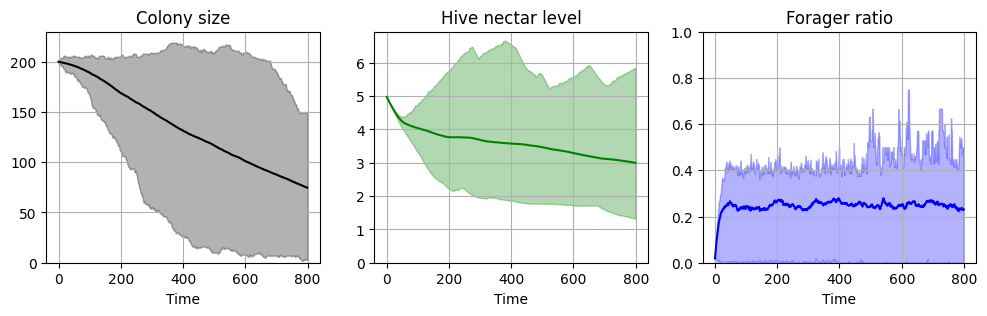

In [11]:
TIME = np.arange(0, BEE_COUNT_DATA.shape[1])

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

axes[0].fill_between(TIME, np.max(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="black", alpha=0.3)
axes[0].plot(TIME, np.mean(BEE_COUNT_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="black")
axes[0].set_title("Colony size")

axes[1].fill_between(TIME, np.max(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="green", alpha=0.3)
axes[1].plot(TIME, np.mean(NECTAR_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="green")
axes[1].set_title("Hive nectar level")

axes[2].fill_between(TIME, np.max(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), np.min(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="blue", alpha=0.3)
axes[2].plot(TIME, np.mean(FORAGER_DATA[FINAL_BEE_COUNT < SURVIVAL_THRESHOLD], axis=0), color="blue")
axes[2].set_title("Forager ratio")
axes[2].set_ylim(0,1)

for ax in axes:
    ax.set_xlabel("Time")
    ax.set_ylim(0,)
    ax.grid()

# 1) Weather resilience experiment

In [12]:
from resource_scarcity_experiment import N_RESOURCES, DIST_RESOURCES, BEE_COUNT_FILE, NECTAR_FILE

In [13]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)

In [14]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

NECTAR = NECTAR_DATA[:, :, :, -1]

NECTAR_SD = np.std(NECTAR, axis=2)
NECTAR_MEAN = np.mean(NECTAR, axis=2)

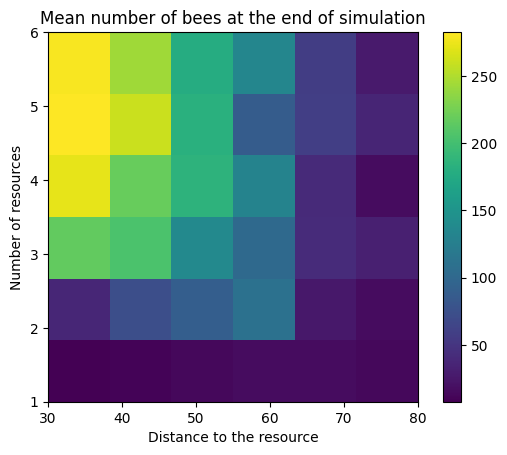

In [15]:
# plt.xlim(DIST_RESOURCES[0], DIST_RESOURCES[1])
plot = plt.imshow(BEE_COUNT_MEAN, extent=(DIST_RESOURCES[0], DIST_RESOURCES[-1], N_RESOURCES[0], N_RESOURCES[-1]), aspect=10, origin="lower")
plt.xlabel("Distance to the resource")
plt.ylabel("Number of resources")
plt.title("Mean number of bees at the end of simulation")
plt.colorbar(plot)

C:\Users\User23718901\AppData\Local\Temp\ipykernel_1668\2978851627.py:9: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=9,12 m=36 fp=0.368569 s=0.000000
  TCK = interpolate.bisplrep(X, Y, data, s=0)


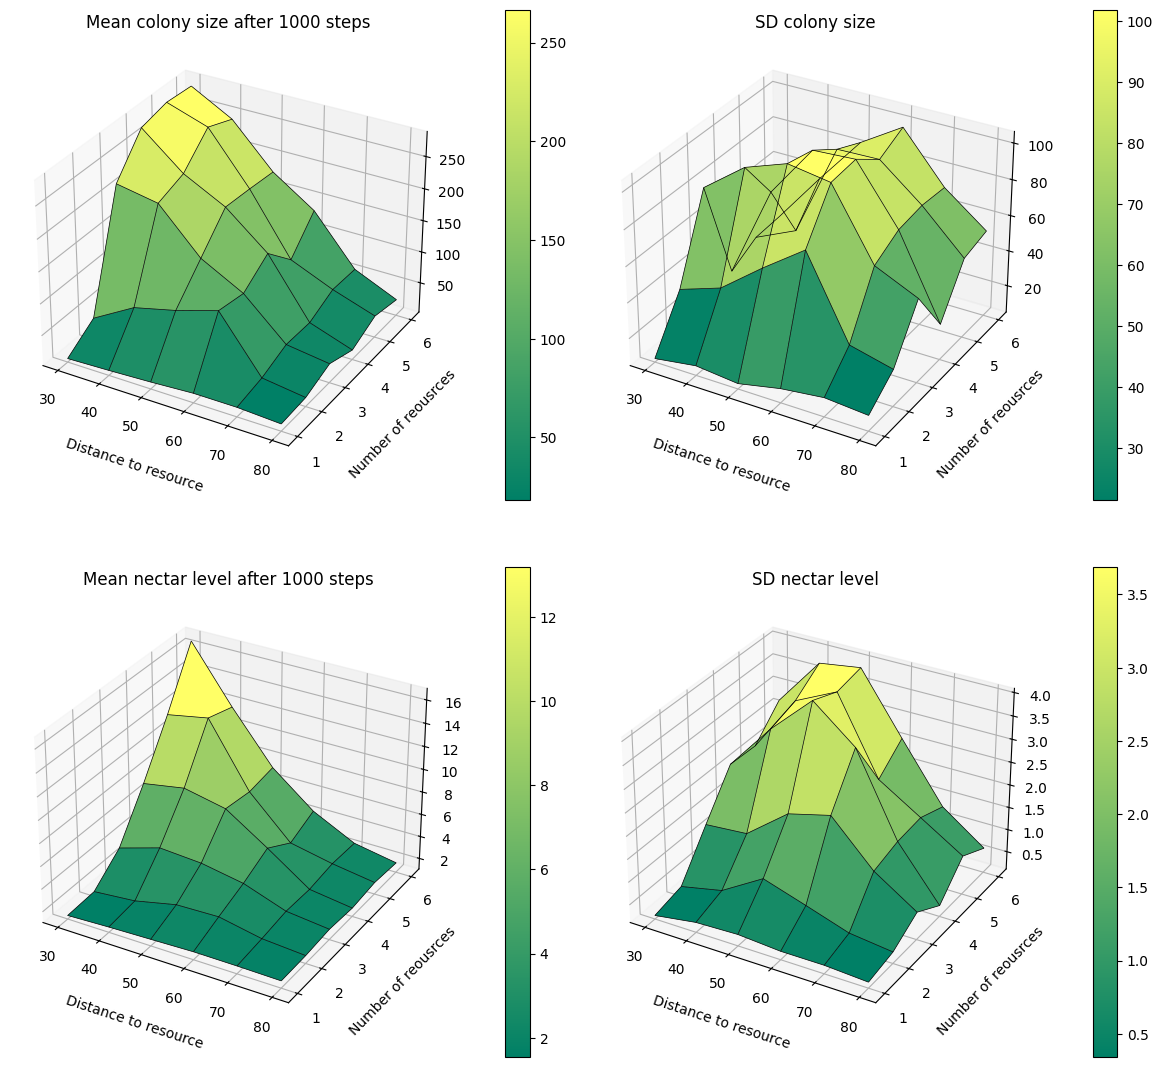

In [16]:
X, Y = np.meshgrid(DIST_RESOURCES, N_RESOURCES)
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(DIST_RESOURCES[0], DIST_RESOURCES[-1], 100), np.linspace(N_RESOURCES[0], N_RESOURCES[-1], 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, NECTAR_MEAN, NECTAR_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    # Smooth out data
    TCK = interpolate.bisplrep(X, Y, data, s=0)
    Z_INTERP = interpolate.bisplev(X_INTERP[:,0], Y_INTERP[0,:], TCK)
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.summer, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Distance to resource", labelpad=10.0)
    ax.set_xticks(DIST_RESOURCES)

    ax.set_ylabel("Number of reousrces", labelpad=10.0)
    ax.set_yticks(N_RESOURCES)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean nectar level after 1000 steps")

axes[1,1].set_title("SD nectar level")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "colony_survival_and_nectar_levels_smooth.png", bbox_inches='tight')
plt.show()

# 2) Resource availability experiment

In [17]:
from weather_effects_experiment import P_STORMS, STORM_DURATIONS, BEE_COUNT_FILE, NECTAR_FILE, EXPLORERS_FILE, RECRUITED_FILE

In [18]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

In [19]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

FORAGERS = np.mean(FORAGER_DATA, axis=3)

FORAGERS_SD = np.std(FORAGERS, axis=2)
FORAGERS_MEAN = np.mean(FORAGERS, axis=2)

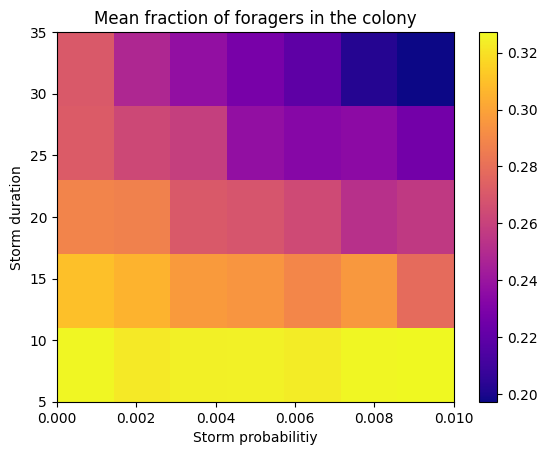

In [20]:
plot = plt.imshow(FORAGERS_MEAN, extent=(P_STORMS[0], P_STORMS[-1], STORM_DURATIONS[0], STORM_DURATIONS[-1]), aspect='auto', origin="lower", cmap="plasma")
plt.xlabel("Storm probabilitiy")
plt.ylabel("Storm duration")
plt.title("Mean fraction of foragers in the colony")
plt.colorbar(plot)

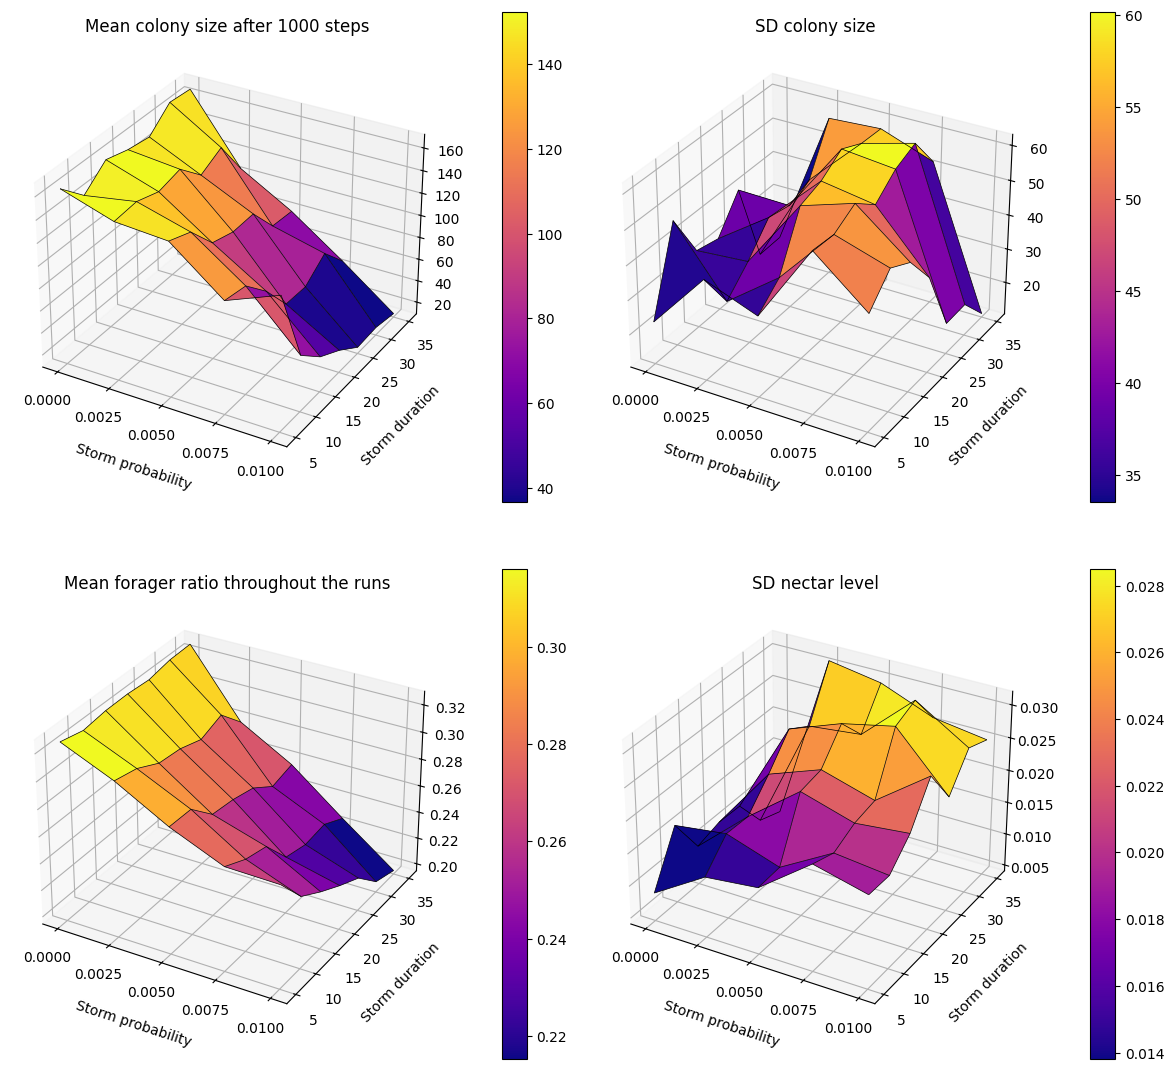

In [21]:
X, Y = np.meshgrid(P_STORMS, STORM_DURATIONS)
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(P_STORMS[0], P_STORMS[-1], 100), np.linspace(STORM_DURATIONS[0], STORM_DURATIONS[-1], 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, FORAGERS_MEAN, FORAGERS_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z.T, cmap=plt.cm.plasma, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z.T, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Storm probability", labelpad=10.0)
    ax.set_xticks(P_STORMS)

    ax.set_ylabel("Storm duration", labelpad=10.0)
    ax.set_yticks(STORM_DURATIONS)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean forager ratio throughout the runs")

axes[1,1].set_title("SD nectar level")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "weather_effects_3d.png", bbox_inches='tight')
plt.show()

# 3) Resource clustering experiment

### Setup

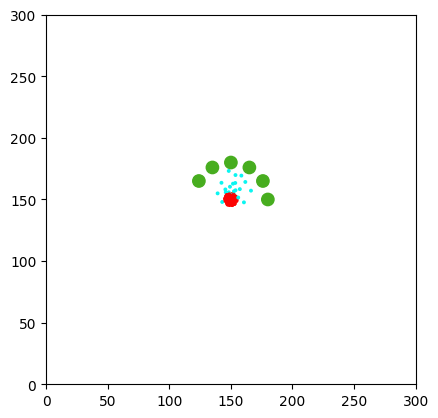

In [22]:
N_RESOURCES = 6

model = ForagerModel()

max_angles = np.arange(2*np.pi / 6, 2*np.pi, 2*np.pi / 6)
ModelBuilder.add_n_resources_in_angle_range(model, 30, 6, max_angles[2])

for _ in range(10):
    model.step()

fig, ax = plt.subplots()
model.plot(ax)

plt.show()

### Results

In [23]:
from resource_clustering_experiment import N_RESOURCE, DIST_RESOURCES, MAX_ANGLES, BEE_COUNT_FILE, NECTAR_FILE, EXPLORERS_FILE, RECRUITED_FILE

In [24]:
BEE_COUNT_DATA = np.load(BEE_COUNT_FILE)
NECTAR_DATA = np.load(NECTAR_FILE)
EXPLORERS_DATA = np.load(EXPLORERS_FILE)
RECRUITED_DATA = np.load(RECRUITED_FILE)

FORAGER_DATA = EXPLORERS_DATA + RECRUITED_DATA

In [25]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

FORAGERS = np.mean(FORAGER_DATA, axis=3)

FORAGERS_SD = np.std(FORAGERS, axis=2)
FORAGERS_MEAN = np.mean(FORAGERS, axis=2)

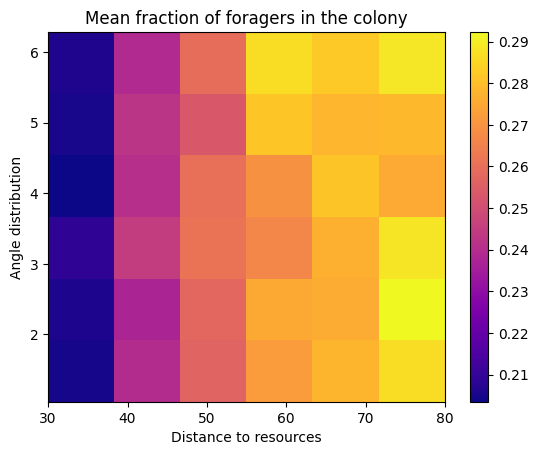

In [26]:
plot = plt.imshow(FORAGERS_MEAN, extent=(DIST_RESOURCES[0], DIST_RESOURCES[-1], MAX_ANGLES[0], MAX_ANGLES[-1]), aspect='auto', origin="lower", cmap="plasma")
plt.xlabel("Distance to resources")
plt.ylabel("Angle distribution")
plt.title("Mean fraction of foragers in the colony")
plt.colorbar(plot)

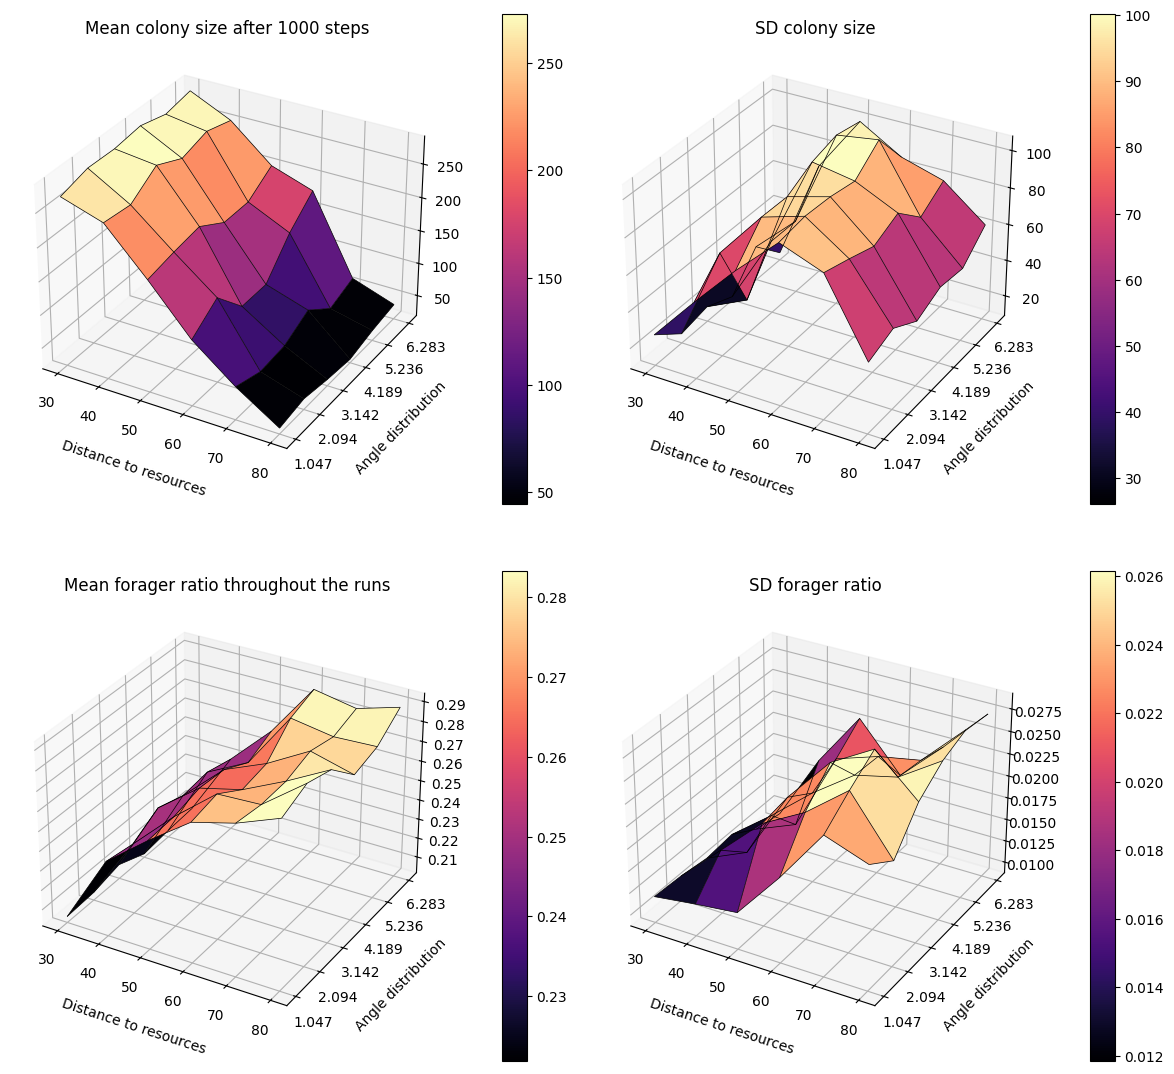

In [27]:
X, Y = np.meshgrid(DIST_RESOURCES, MAX_ANGLES)

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, FORAGERS_MEAN, FORAGERS_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z, cmap=plt.cm.magma, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Distance to resources", labelpad=10.0)
    ax.set_xticks(DIST_RESOURCES)

    ax.set_ylabel("Angle distribution", labelpad=10.0)
    ax.set_yticks(MAX_ANGLES)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean forager ratio throughout the runs")

axes[1,1].set_title("SD forager ratio")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "resource_clustering.png", bbox_inches='tight')
plt.show()

# 4) Sensitivity analysis

In [84]:
from sensitivity_analysis_initial_conditions import PARAMS, PROBLEM, N_SAMPLES, DATA_COLLECTORS, SAVE_PATH

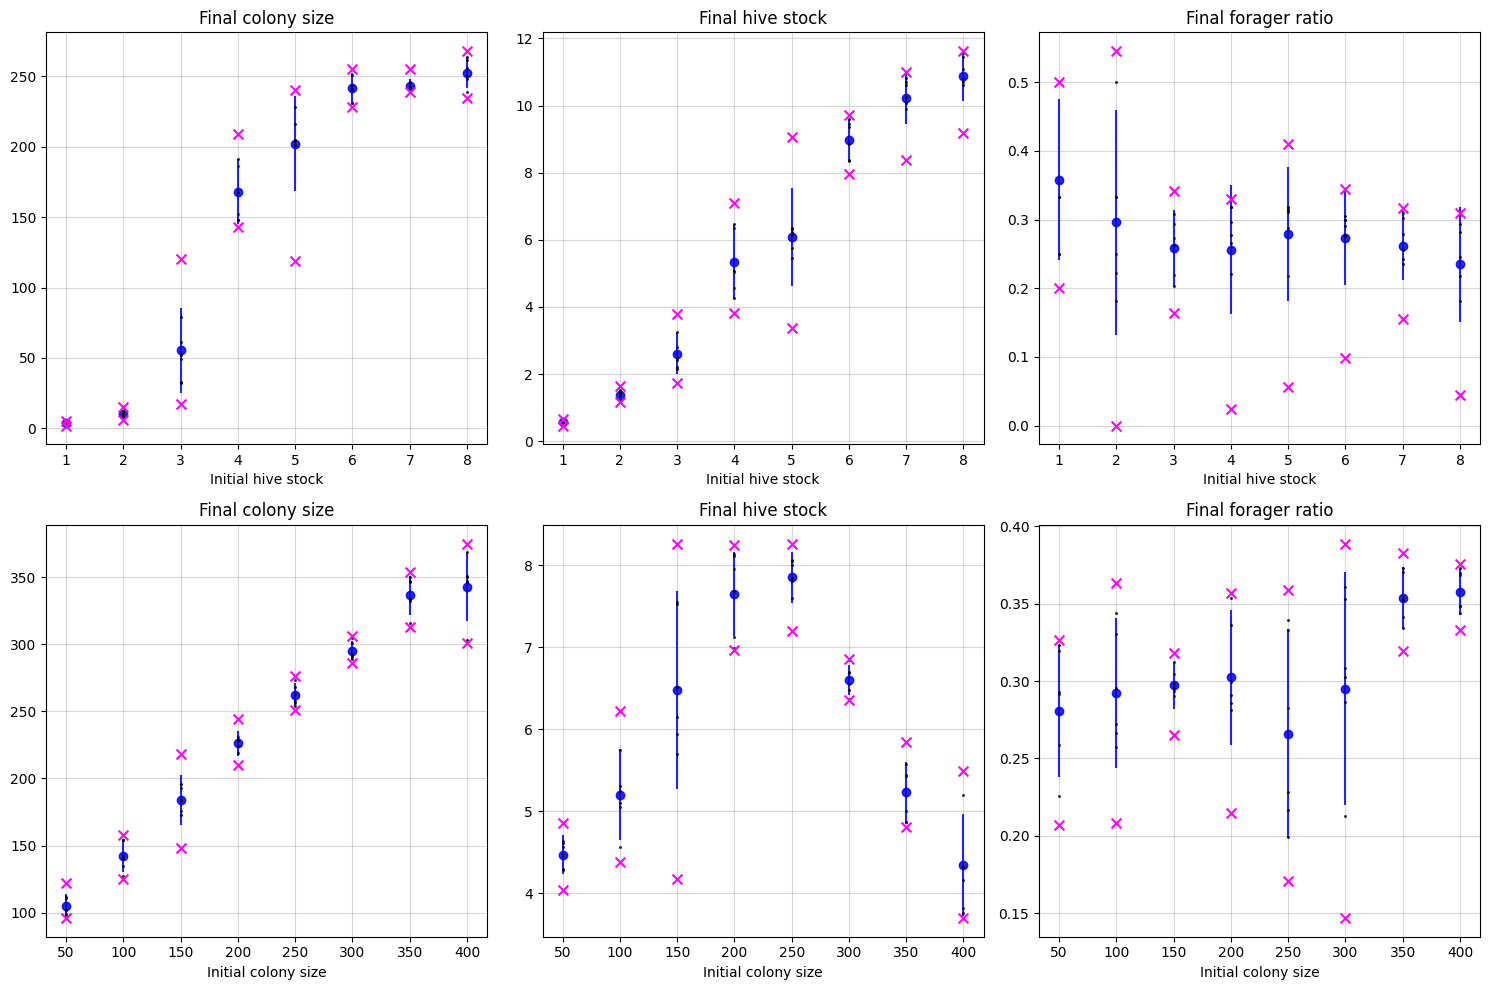

In [85]:
fig, axes = plt.subplots(len(PARAMS), len(DATA_COLLECTORS), figsize=(15,5*len(PARAMS)))

PLOT_TITLES = ['Final colony size', 'Final hive stock', 'Final forager ratio']
AXIS_LABELS = ['Initial hive stock', 'Initial colony size']

for (i, PARAM) in enumerate(PARAMS):
    DATA = np.load(os.path.join(SAVE_PATH,  PARAM + ".npy"))
    DOMAIN = np.linspace(PROBLEM['bounds'][i][0], PROBLEM['bounds'][i][1], N_SAMPLES)

    for j, (name, ax) in enumerate(zip(PLOT_TITLES, axes[i])):
        ax.grid(alpha=0.5)
        ax.set_xticks(DOMAIN)
        ax.set_xlabel(AXIS_LABELS[i])
        ax.set_title(PLOT_TITLES[j])

    for X_POINT in DOMAIN:
        DATA_CHUNK = DATA[DATA[:, 0] == X_POINT]

        for (k, ax) in enumerate(axes[i]):

            # Mean and standard deviation
            ax.errorbar(X_POINT, np.mean(DATA_CHUNK[:, k + 1]), np.std(DATA_CHUNK[:, k + 1]), fmt="ob", lw=1.5, alpha=0.85)

            # All data point
            for Y_POINT in DATA_CHUNK[:, k + 1]:
                ax.scatter(X_POINT, Y_POINT, c='k', s=1.5, zorder=10, alpha=0.7)
            
            # Min and max
            ax.scatter(X_POINT, np.max(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')
            ax.scatter(X_POINT, np.min(DATA_CHUNK[:, k + 1]), c='magenta', s=50, zorder=10, marker='x')

fig.tight_layout()
plt.show()

In [ ]:
BEE_COUNT = BEE_COUNT_DATA[:, :, :, -1]

BEE_COUNT_SD = np.std(BEE_COUNT, axis=2)
BEE_COUNT_MEAN = np.mean(BEE_COUNT, axis=2)

FORAGERS = np.mean(FORAGER_DATA, axis=3)

FORAGERS_SD = np.std(FORAGERS, axis=2)
FORAGERS_MEAN = np.mean(FORAGERS, axis=2)

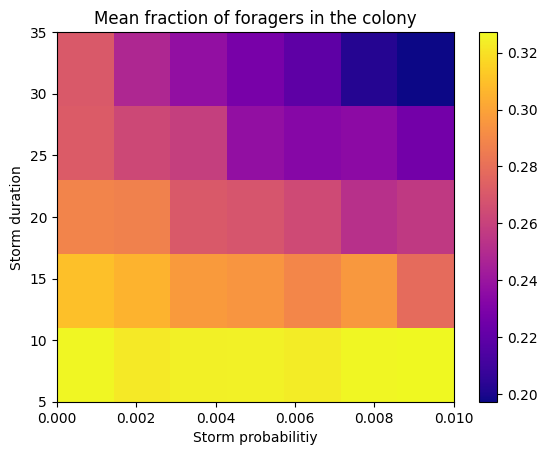

In [ ]:
plot = plt.imshow(FORAGERS_MEAN, extent=(P_STORMS[0], P_STORMS[-1], STORM_DURATIONS[0], STORM_DURATIONS[-1]), aspect='auto', origin="lower", cmap="plasma")
plt.xlabel("Storm probabilitiy")
plt.ylabel("Storm duration")
plt.title("Mean fraction of foragers in the colony")
plt.colorbar(plot)

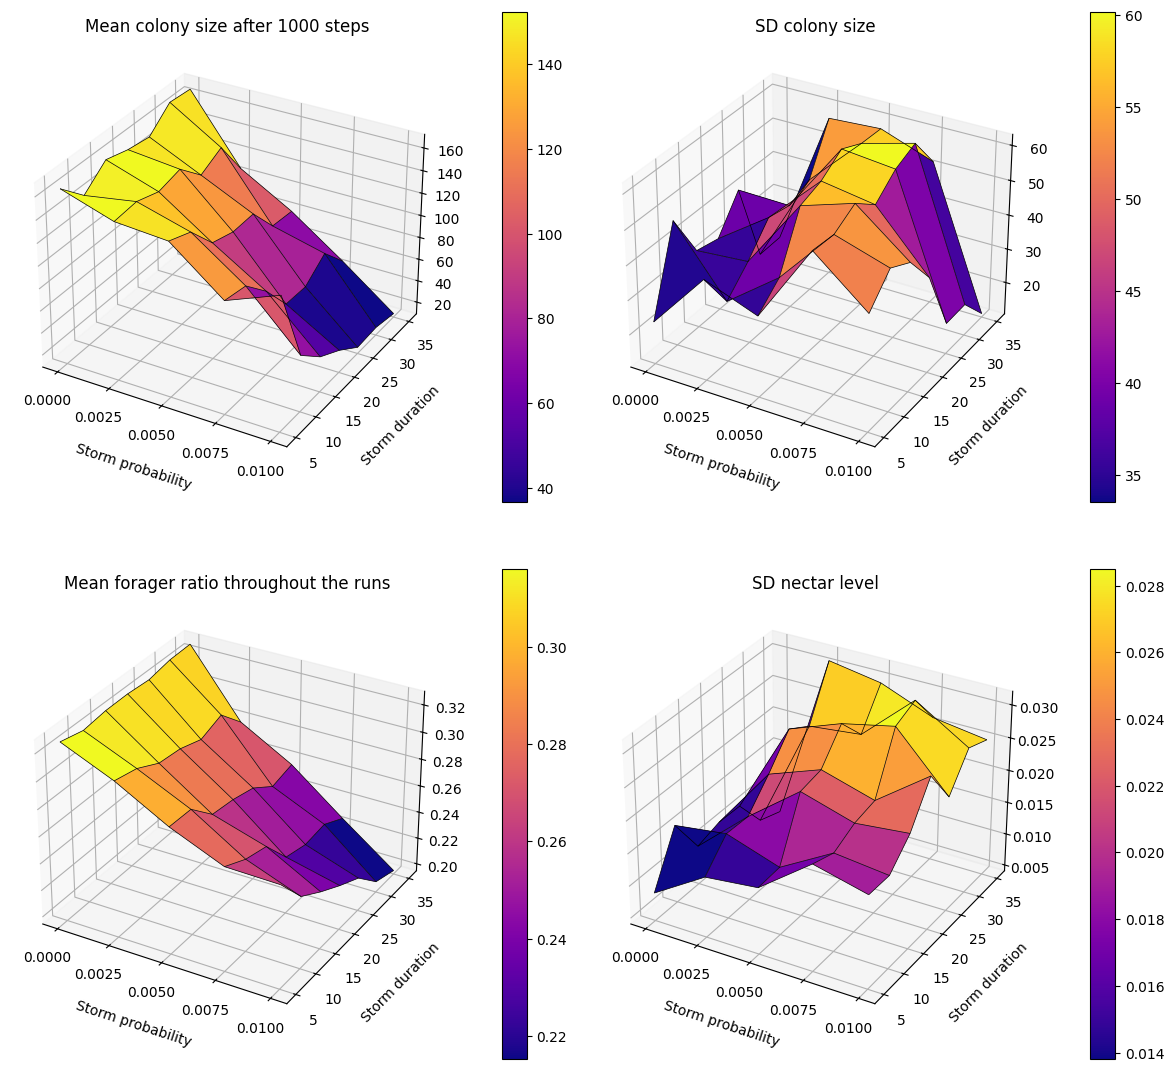

In [ ]:
X, Y = np.meshgrid(P_STORMS, STORM_DURATIONS)
X_INTERP, Y_INTERP = np.meshgrid(np.linspace(P_STORMS[0], P_STORMS[-1], 100), np.linspace(STORM_DURATIONS[0], STORM_DURATIONS[-1], 100))

fig, axes = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(12, 12))
plot_data = [BEE_COUNT_MEAN, BEE_COUNT_SD, FORAGERS_MEAN, FORAGERS_SD]

for (data, ax) in zip(plot_data, axes.flatten()):
    Z = data

    # Plot data
    surf = ax.plot_surface(X, Y, Z.T, cmap=plt.cm.plasma, alpha=None, antialiased=True)
    ax.plot_wireframe(X, Y, Z.T, lw=0.5, color='black', alpha=None, antialiased=True)

    # Plot settings & colorbar
    ax.set_xlabel("Storm probability", labelpad=10.0)
    ax.set_xticks(P_STORMS)

    ax.set_ylabel("Storm duration", labelpad=10.0)
    ax.set_yticks(STORM_DURATIONS)

    fig.colorbar(surf, ax=ax, shrink=0.8, aspect=20, pad=0.1)

axes[0,0].set_title("Mean colony size after 1000 steps")

axes[0,1].set_title("SD colony size")

axes[1,0].set_title("Mean forager ratio throughout the runs")

axes[1,1].set_title("SD nectar level")

plt.tight_layout()
plt.savefig(FIGURE_PATH + "weather_effects_3d.png", bbox_inches='tight')
plt.show()